In [1]:
#-------------------------Setting the randomness-----------#

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3,4,5,6,7"  # specify which GPU(s) to be used
import cv2 as cv2

import numpy as np
np.random.seed(1) # for reproducability

from tensorflow import set_random_seed
set_random_seed(1) # for reproducability
#------------------------------------------------------#
import keras
from keras.models import Sequential
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,MaxPool2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten, Activation,Reshape

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split



/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
from numpy import load
train_data = load('data/training_data_250_3channel.npy')
test_data = load('data/testing_data_250_3channel.npy')

In [3]:
def balanced(option):
    if(option=="yes"):
        training_data = np.concatenate((train_data[0:1341],train_data[3875:]),axis=0)
        testing_data = np.concatenate((test_data[0:234],test_data[390:]))
        return training_data,testing_data
    else:
        training_data = train_data
        testing_data = test_data
        return training_data,testing_data


In [4]:
training_data,test_data=balanced("no")
print(training_data.shape)
print(test_data.shape)

(5216, 187501)
(624, 187501)


In [5]:
X_train,X_val,Y_train,Y_val = train_test_split(training_data[0:,1:],training_data[0:,0:1],test_size=0.1,random_state = 1,shuffle=True,stratify=training_data[0:,0:1])

In [6]:
print('All (class distribution):', np.bincount(list(map(float, training_data[0:,0:1]))) / float(len(training_data)) * 100.0)
print('Training (class distribution):', np.bincount(list(map(float,Y_train))) / float(len(Y_train)) * 100.0)
print('Validation (class distribution):', np.bincount(list(map(float,Y_val))) / float(len(Y_val)) * 100.0)

All (class distribution): [25.70935583 74.29064417]
Training (class distribution): [25.71367703 74.28632297]
Validation (class distribution): [25.67049808 74.32950192]


In [7]:
X_test = test_data[0:,1:]
Y_test = test_data[0:,0:1]

In [8]:
y_train_ohe = keras.utils.to_categorical(Y_train, 2)
y_test_ohe = keras.utils.to_categorical(Y_test, 2)
y_val_ohe = keras.utils.to_categorical(Y_val,2)

In [9]:
X_train = X_train.reshape(X_train.shape[0],250,250,3)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0],250,250,3)
print(X_test.shape)
X_val = X_val.reshape(X_val.shape[0],250,250,3)
print(X_val.shape)

(4694, 250, 250, 3)
(624, 250, 250, 3)
(522, 250, 250, 3)


In [10]:
def create_model():
        model = Sequential()
    
        model.add(Conv2D(input_shape=(250,250,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
        model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strrides=(2,2)))
        
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
        
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
        model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
        model.add(Flatten())
    
        model.add(Dense(128))
        model.add(Activation('relu'))

        model.add(Dropout(0.1))

        model.add(Dense(64))
        model.add(Activation('relu'))



        model.add(Dense(2))
        model.add(Activation('softmax'))

    
    
        return model

In [11]:
history_array = [] ## Used to get callbacks for 10 models
accuracy = [] ## Compute the accuracy from 10 models
model_array = [] # Save 10 models to array to be used for computing the test and returning predictions which are for printing confusion matrix
for i in range(0,5):
    model = create_model()  
    opt = optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    np.random.seed(1) # for reproducability
    #shuffle= false needs to be used if u want results to be the same every time
    history = model.fit(X_train, y_train_ohe,shuffle=True,batch_size=64,epochs=20,validation_data=(X_val, y_val_ohe))# model
    model_array.append(model)
    history_array.append(history)
    score = model.evaluate(X_test, y_test_ohe)
    accuracy.append(score)

W0426 23:28:27.671289 140475344578368 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0426 23:28:27.697511 140475344578368 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0426 23:28:28.718166 140475344578368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Train on 4694 samples, validate on 522 samples
Epoch 1/20
4694/4694 [==============================] - 54s 11ms/step - loss: 0.6173 - accuracy: 0.7348 - val_loss: 0.6265 - val_accuracy: 0.7433
Epoch 2/20
4694/4694 [==============================] - 47s 10ms/step - loss: 0.5790 - accuracy: 0.7429 - val_loss: 0.5220 - val_accuracy: 0.7433
Epoch 3/20
4694/4694 [==============================] - 46s 10ms/step - loss: 0.3948 - accuracy: 0.8191 - val_loss: 0.1820 - val_accuracy: 0.9234
Epoch 4/20
4694/4694 [==============================] - 46s 10ms/step - loss: 0.1721 - accuracy: 0.9320 - val_loss: 0.1060 - val_accuracy: 0.9674
Epoch 5/20
4694/4694 [==============================] - 46s 10ms/step - loss: 0.1078 - accuracy: 0.9578 - val_loss: 0.0838 - val_accuracy: 0.9693
Epoch 6/20
4694/4694 [==============================] - 46s 10ms/step - loss: 0.0916 - accuracy: 0.9666 - val_loss: 0.0838 - val_accuracy: 0.9674
Epoch 7/20
4694/4694 [==============================] - 46s 10ms/step - loss:

In [12]:
accuracy

[[2.0028287023150573, 0.7884615659713745],
 [1.0218689043831546, 0.8141025900840759],
 [1.9637710224296374, 0.7980769276618958],
 [2.400089985155412, 0.754807710647583],
 [2.668519704385377, 0.7628205418586731]]

[0.7347678, 0.74286324, 0.8191308, 0.9320409, 0.9578185, 0.96655303, 0.9706008, 0.97677886, 0.97209203, 0.9825309, 0.98231786, 0.98423517, 0.98444825, 0.98849595, 0.988922, 0.994248, 0.9891351, 0.9936089, 0.9957392, 0.9927567]
[0.7432950139045715, 0.7432950139045715, 0.9233716726303101, 0.967432975769043, 0.969348669052124, 0.967432975769043, 0.975095808506012, 0.9808428883552551, 0.982758641242981, 0.982758641242981, 0.9731800556182861, 0.9808428883552551, 0.9808428883552551, 0.982758641242981, 0.9808428883552551, 0.9885057210922241, 0.9808428883552551, 0.9865900278091431, 0.977011501789093, 0.9885057210922241]


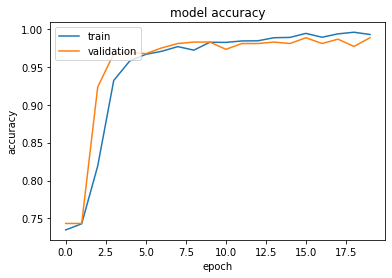

[0.74286324, 0.9160631, 0.9561142, 0.95930976, 0.96591395, 0.9735833, 0.9793353, 0.98210484, 0.98295695, 0.98444825, 0.98508734, 0.98444825, 0.9857265, 0.9835961, 0.98849595, 0.9904133, 0.98785686, 0.99403495, 0.99510014, 0.994674]
[0.8505747318267822, 0.954023003578186, 0.9501915574073792, 0.9712643623352051, 0.9731800556182861, 0.977011501789093, 0.9789271950721741, 0.9731800556182861, 0.9712643623352051, 0.9808428883552551, 0.969348669052124, 0.982758641242981, 0.984674334526062, 0.9655172228813171, 0.982758641242981, 0.984674334526062, 0.977011501789093, 0.982758641242981, 0.9865900278091431, 0.977011501789093]


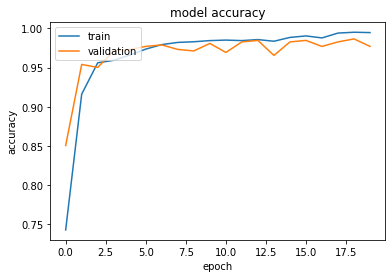

[0.7443545, 0.91989774, 0.9595228, 0.9657009, 0.9674052, 0.97123986, 0.9761397, 0.9804005, 0.9793353, 0.98317003, 0.98295695, 0.9867917, 0.9812527, 0.98402214, 0.9893481, 0.9931828, 0.9893481, 0.9925437, 0.98317003, 0.9904133]
[0.7988505959510803, 0.9559386968612671, 0.9789271950721741, 0.9655172228813171, 0.969348669052124, 0.975095808506012, 0.975095808506012, 0.975095808506012, 0.9731800556182861, 0.969348669052124, 0.9731800556182861, 0.9712643623352051, 0.984674334526062, 0.967432975769043, 0.9731800556182861, 0.9731800556182861, 0.975095808506012, 0.9808428883552551, 0.982758641242981, 0.982758641242981]


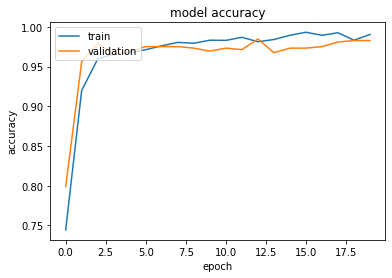

[0.7445675, 0.91925865, 0.95078826, 0.96357054, 0.96889645, 0.971666, 0.9791223, 0.9806135, 0.9812527, 0.9804005, 0.9835961, 0.98317003, 0.9816787, 0.9870047, 0.98849595, 0.99083936, 0.98785686, 0.99083936, 0.99083936, 0.98977417]
[0.7375478744506836, 0.9367815852165222, 0.9425287246704102, 0.967432975769043, 0.9559386968612671, 0.984674334526062, 0.977011501789093, 0.9808428883552551, 0.9655172228813171, 0.9808428883552551, 0.961685836315155, 0.99042147397995, 0.9808428883552551, 0.9712643623352051, 0.975095808506012, 0.982758641242981, 0.982758641242981, 0.9865900278091431, 0.982758641242981, 0.9808428883552551]


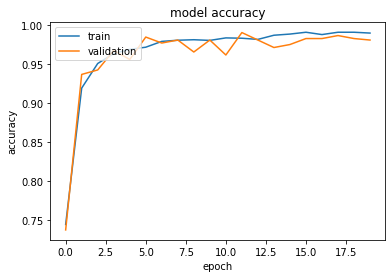

[0.7479761, 0.90477204, 0.9544099, 0.96250534, 0.9676182, 0.9752876, 0.9759267, 0.9793353, 0.98189175, 0.98402214, 0.9835961, 0.98636556, 0.97848314, 0.98636556, 0.98743075, 0.9916915, 0.9923306, 0.99062634, 0.9938219, 0.99062634]
[0.7068965435028076, 0.9655172228813171, 0.9425287246704102, 0.969348669052124, 0.9655172228813171, 0.9808428883552551, 0.969348669052124, 0.9808428883552551, 0.975095808506012, 0.975095808506012, 0.967432975769043, 0.9885057210922241, 0.982758641242981, 0.9731800556182861, 0.9865900278091431, 0.982758641242981, 0.9808428883552551, 0.977011501789093, 0.9865900278091431, 0.984674334526062]


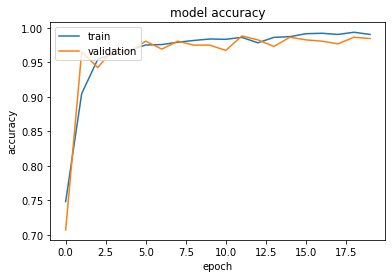

In [14]:

import matplotlib.pyplot as plt
count = 0; 


for i in history_array:
    print(i.history['accuracy'])
    plt.plot(i.history['accuracy'])
    print(i.history['val_accuracy'])
    plt.plot(i.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','validation'],loc='upper left')
    name = 'train_vs_validation_accuracy' + str(count) + '.png'
    #plt.savefig('experiment2/'+name)
    plt.show()



[0.6173298874204088, 0.5790364022426622, 0.394837157341283, 0.17209639452623213, 0.10775523808315352, 0.09160610983123614, 0.0755757510465259, 0.06466666874120629, 0.07409678965260945, 0.049610516885263765, 0.04461218679143639, 0.04113597399902359, 0.04616391956353815, 0.028891171677919793, 0.0314907815320176, 0.016345974186021763, 0.02726629171814114, 0.017343199007335334, 0.015521326441393986, 0.01640383510248552]
[0.6264763483599228, 0.5220400031042282, 0.18198277107600508, 0.1060396295854415, 0.08381966515747523, 0.08376962688690857, 0.0633860431411714, 0.06851397763038504, 0.05511973478556593, 0.06271632453176938, 0.0665953031444915, 0.047729645081406806, 0.08003036409502286, 0.05622894730832842, 0.05470249121402073, 0.05642507025451039, 0.05217009413830394, 0.04883978016303417, 0.06862763322932625, 0.05383307637711023]


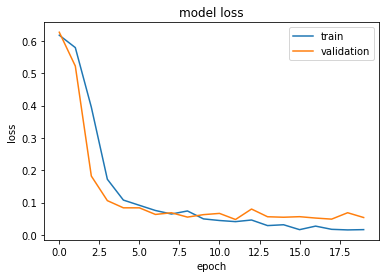

[0.576391129085852, 0.21708239311480146, 0.11871005303508546, 0.1039470774306101, 0.09329974535149516, 0.0707045117743126, 0.06103816615758066, 0.052489947696689805, 0.050707860781148896, 0.045773248965159524, 0.04036454105464814, 0.044270961043438, 0.04185933606245947, 0.04183924727996595, 0.03704754987983156, 0.025423727183184905, 0.033314416668737724, 0.017525380865790183, 0.01332823036880869, 0.015267708659100434]
[0.506083548639926, 0.11025334980295992, 0.11708192964052332, 0.08218346790221459, 0.06372802107955304, 0.052266639254102305, 0.06902496094219529, 0.07195761948253003, 0.06381548924007635, 0.0480057650256431, 0.07705715064573106, 0.042160559438483014, 0.04145081735205376, 0.1482513564071436, 0.053597893408888604, 0.0436050181073704, 0.040396063320938196, 0.04279017839509409, 0.054515462054717585, 0.04785856801545483]


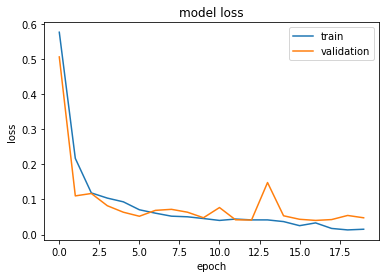

[0.571672288417613, 0.21082788407739092, 0.11708246364008634, 0.09117125224879208, 0.0881607775065713, 0.07704478949562356, 0.06849605871843031, 0.062461508883216506, 0.05610610127153806, 0.04695337986066449, 0.04760146006452921, 0.04121684997184198, 0.05259148714271095, 0.04208759862880378, 0.027521900615992575, 0.020642538446735418, 0.03156988282636773, 0.0185679726276434, 0.04886611869102753, 0.02351174949509424]
[0.4800984667635512, 0.12334443049298392, 0.0991339719501035, 0.09536398176489205, 0.07493776345618383, 0.06195447870826356, 0.06131326815406025, 0.062280759971831495, 0.05902631366732477, 0.0683169508231554, 0.0867267272138961, 0.08441307145202982, 0.05036158397279937, 0.07568890016197702, 0.06214747415191826, 0.06237500868880429, 0.06617969628494819, 0.05710683654551305, 0.055728664257745635, 0.04923580124460418]


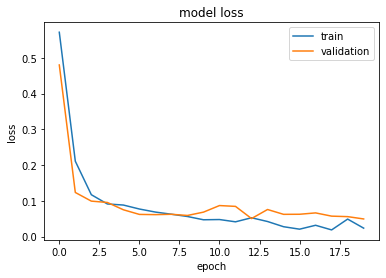

[0.5734120012345495, 0.2061086237544855, 0.13251707918821343, 0.10020859307134512, 0.09452995139364237, 0.07677836976643822, 0.061467023995718045, 0.05763366778667272, 0.06008726526821579, 0.05660162954247971, 0.05061312830277997, 0.05045421747074109, 0.055179586998315176, 0.03861502565453039, 0.03593671101279966, 0.02616412244803813, 0.036513084729258044, 0.029780374217499087, 0.027917974829097594, 0.03191613990652139]
[0.5353303885094507, 0.15438446242690543, 0.12387725539591121, 0.09133171170264826, 0.10155035007274014, 0.050470344836456106, 0.058771511290036854, 0.05473929986186411, 0.09587244580988682, 0.05303831379932005, 0.09541967722419578, 0.03388845453830971, 0.05224612409470182, 0.07076549587121868, 0.058194585372890094, 0.09218140232280411, 0.06051511405449775, 0.052983968650700944, 0.0576970420806344, 0.04980844669971772]


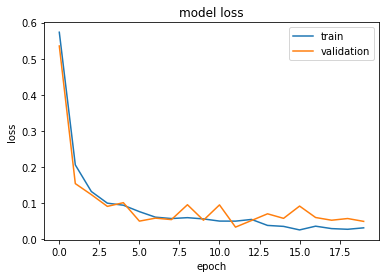

[0.5703829489315019, 0.242734716453601, 0.1157061451046859, 0.09759784170196673, 0.09122015549323129, 0.07231878186248697, 0.06683645291475347, 0.06255811849917739, 0.058287650799124, 0.04600054283162502, 0.04877584006337343, 0.04232465045690905, 0.05454232335339836, 0.03847526269359732, 0.03306040535040095, 0.024316732658602656, 0.02159071524048555, 0.027088995511843187, 0.01607056452984385, 0.022172425558011223]
[0.5528043448011537, 0.10593726151976092, 0.12935261913643029, 0.08761137980839302, 0.07812197392242622, 0.05379639617327986, 0.07806291947876356, 0.05887183053169214, 0.054550668859847204, 0.051401548487244896, 0.08432069883264344, 0.04366374111438163, 0.05960417661630331, 0.08335920625947901, 0.0415958681989504, 0.0533767147025386, 0.047227710157176084, 0.08546952198177461, 0.04318238884813627, 0.04482854497476242]


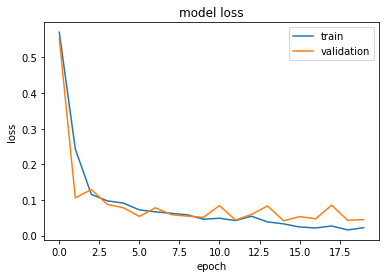

In [15]:
# summarize history for loss

count = 0 
for i in history_array:
    print(i.history['loss'])
    plt.plot(i.history['loss'])
    plt.plot(i.history['val_loss'])
    print(i.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    name = 'train_vs_test_loss_shuffled_btch32_' + str(count) + '.png'
    #plt.savefig(name)
    count = count +1
    plt.show()    
    
  

In [16]:
from sklearn.metrics import confusion_matrix
def classification_report():
    
    for i in model_array:
        y_pred = i.predict_classes(X_test)
        matrix = ["TN","FP"],["FN","TP"]
        print(matrix[0])
        print(matrix[1])

        ##Lets Visualise the output
        conf=confusion_matrix(Y_test, y_pred)
        print("Confusion Matrix")
        print(conf)
        # or we can use a heatmap from the seaborn library
        #import seaborn as sn
        #df_cm = pandas.DataFrame(conf, range(2), range(2))
        #sn.set(font_scale=1.4)#for label size
        #sn.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 20},fmt="d")# font size

        from sklearn.metrics import classification_report
        print(classification_report(Y_test,y_pred));
        



In [17]:
classification_report()

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[106 128]
 [  4 386]]
              precision    recall  f1-score   support

         0.0       0.96      0.45      0.62       234
         1.0       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.74       624
weighted avg       0.83      0.79      0.76       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[121 113]
 [  3 387]]
              precision    recall  f1-score   support

         0.0       0.98      0.52      0.68       234
         1.0       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624

['TN', 'FP']
['FN', 'TP']
Confusion Matrix
[[108 126]
 [  0 390]]
              precision    recall  f1-score   support

         0.0       1.00      0.46      0.63       234
         1.0       0.76      1.00      